Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from statsmodels.formula.api import ols
import statsmodels.api as sm

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from custom_functions import * #remove_extremes

Import dataset that was cleaned and prepared in Data Preparation notebook

In [2]:
conn = sqlite3.connect('../../data/processed/main.db')
query = '''SELECT * FROM step2_encoded'''
df_main = pd.read_sql(query, conn, index_col='index').reset_index(drop=True)
conn.close()

df_main.head(3)
y = 'SalePrice'

In [3]:
def remove_df_extremes(df, devct, drop_zeros=False):
    
    for col in df.columns:
        df[col] = [float(num) for num in df[col]]
        med = df[col].median()
        std = df[col].std()

        max_ = med + devct*std
        min_ = 0.0000001 if drop_zeros else med - devct*std 

        df[col] = [x if ((x>min_) & (x<max_)) else np.nan for x in df[col]]
    df.dropna(inplace=True)
    return df

In [4]:
def produce_model(df, x, y, devct, drop_zeros=False):
    model_data = pd.concat([df[y], df[x]], axis=1)
    model_data_trimmed = remove_df_extremes(model_data, devct, drop_zeros)

    formula = y + ' ~ ' + '+'.join(xs)
    
    #formula_TESTING = 'SalePrice ~ SqFtTotLiving+Bedrooms+YrBuilt+Condition+Stories'
    model = ols(formula, model_data_trimmed).fit()
    print(formula)
    
    return model, model_data_trimmed

In [5]:
def qq(df, col):
    plt.figure(figsize=(12,6));
    sm.graphics.qqplot(df[col], line='45', fit=True)
    plt.title(f'Normality Assumption Check: QQ plot of {col} values');

In [6]:
def dist(df, x):
    plt.figure(figsize=(12,6));
    sns.distplot(df[x])
    plt.title(f'Distribution of {x} (KDE)')

In [7]:
def scatter(df, x, model):
    plt.figure(figsize=(12, 6));
    sns.lmplot(data = df, x=x, y=y, line_kws={'color':'r'})    
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'Linearity Assumption: {x} vs. {y}');

In [8]:
# STEPWISE SELECTOR
non_na = df_main.dropna()
X = non_na.drop(y, axis=1)
Y = non_na[y]
results = stepwise_selection(X, Y, verbose=False)
#results

In [13]:
df_main.drop(y, axis=1).columns

Index(['NbrLivingUnits', 'Stories', 'BldgGrade', 'SqFtTotLiving',
       'SqFtTotBasement', 'FinBasementGrade', 'SqFtGarageAttached',
       'DaylightBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'HeatSystem', 'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'YrBuilt', 'YrRenovated', 'Condition', 'SaleInstrument',
       'forced_air_vs_other', 'SqFtUnfinished', 'Bathrooms', 'Fireplaces'],
      dtype='object')

In [44]:
exclude_these_features = [y, 'SqFtEnclosedPorch', 'SqFtUnfinished', 'FinBasementGrade', 'HeatSystem', 'BrickStone', 'ViewUtilization', 'DaylightBasement', 'SqFtTotBasement']
xs = df_main.drop(exclude_these_features, axis=1).columns

model, df_trimmed = produce_model(df_main, xs, y, 3)
x = 'Fireplaces'


#sm.graphics.plot_regress_exog(model, x, fig=plt.figure(figsize=(15,8)));

model.summary()

# qq(df_trimmed, x);
# dist(df_trimmed, x)
# scatter(df_trimmed, x, model)

SalePrice ~ NbrLivingUnits+Stories+BldgGrade+SqFtTotLiving+SqFtGarageAttached+SqFtOpenPorch+SqFtDeck+HeatSource+Bedrooms+YrBuilt+YrRenovated+Condition+SaleInstrument+forced_air_vs_other+Bathrooms+Fireplaces


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     1282.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:17:54   Log-Likelihood:            -2.1419e+05
No. Observations:               15552   AIC:                         4.284e+05
Df Residuals:                   15537   BIC:                         4.285e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.949e+06   1.16e+05     25.359      0.000    2.72e+06    3.18e+06
NbrLivingUnits       2.949e+06   1.16e+05     25.359      0.000    2.72e+06    3.18e+06
Stories              4.146e+04   4894.181      8.471      0.000    3.19e+04    5.11e+04
BldgGrade            1.753e+05   2930.982     59.799      0.000     1.7e+05    1.81e+05
SqFtTotLiving         156.9799      4.847     32.385      0.000     147.479     166.481
SqFtGarageAttached   -187.0783      8.424    -22.208      0.000    -203.590    -170.567
SqFtOpenPorch         157.3897     23.608      6.667      0.000     111.115     203.665
SqFtDeck               69.1117     12.589      5.490      0.000      44.436      93.788
HeatSource          -2.108e+04   4138.039     -5.095      0.000   -2.92e+04    -1.3e+04
Bedrooms            -3.591e+04   3059.662    -11.736      0.000   -4.19e+04   -2.99e+04
YrBuilt             -3645.3318     96.812    -37.654      0.000   -3835.095   -3455.569
YrRenovated          4.051e-09   1.76e-10     22.963      0.000     3.7e-09     4.4e-09
Condition            1.518e+04   3020.735      5.024      0.000    9254.998    2.11e+04
SaleInstrument       1.318e+05   4.65e+04      2.836      0.005    4.07e+04    2.23e+05
forced_air_vs_other -4.368e+04   5256.383     -8.310      0.000    -5.4e+04   -3.34e+04
Bathrooms            5.308e+04   4685.125     11.330      0.000    4.39e+04    6.23e+04
Fireplaces          -2.348e+04   3355.956     -6.995      0.000   -3.01e+04   -1.69e+04
==============================================================================
Omnibus:                     3490.426   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12930.128
Skew:                           1.091   Prob(JB):                         0.00
Kurtosis:                       6.898   Cond. No.                     2.01e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.22e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

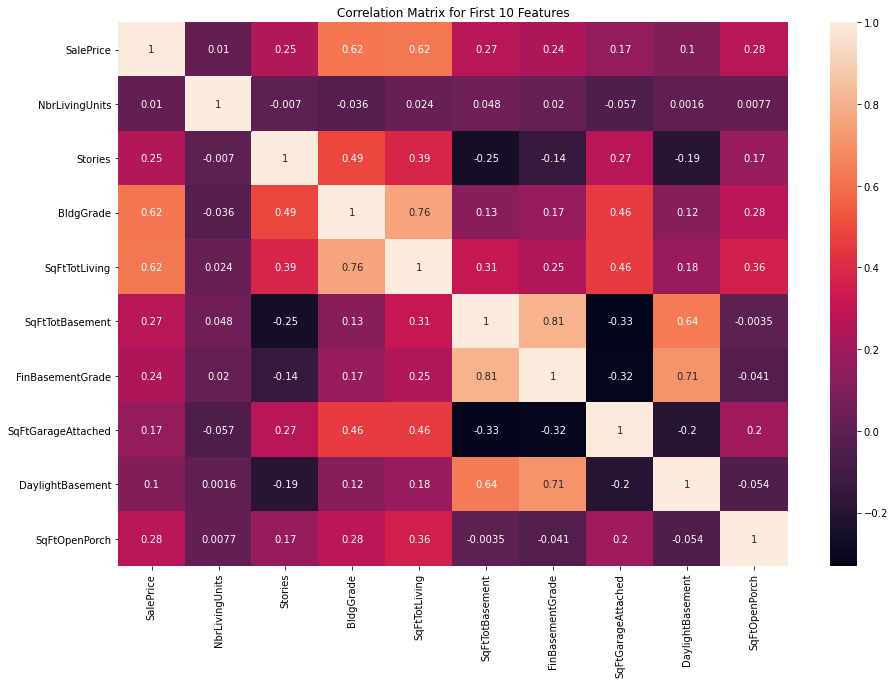

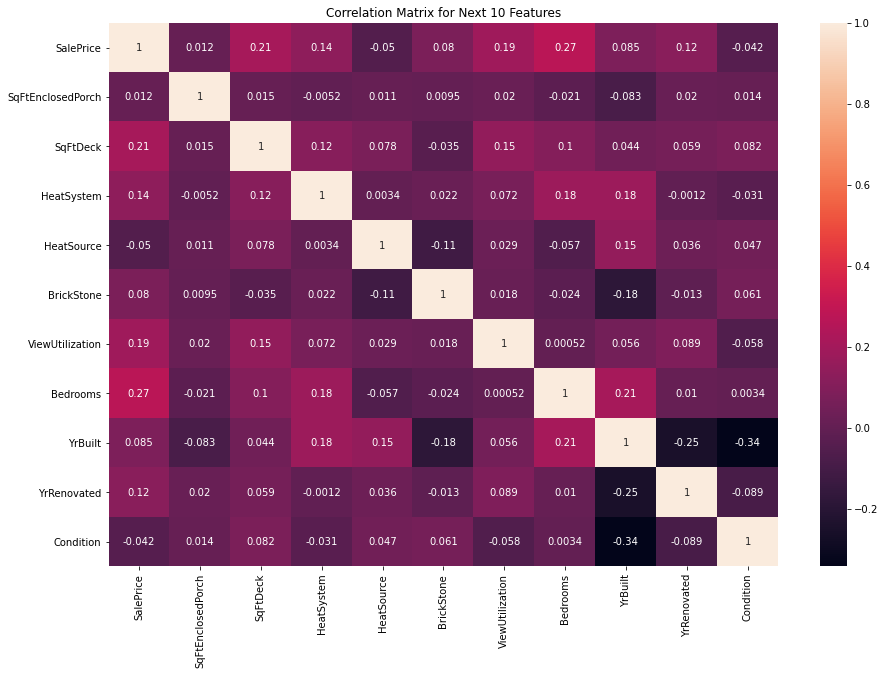

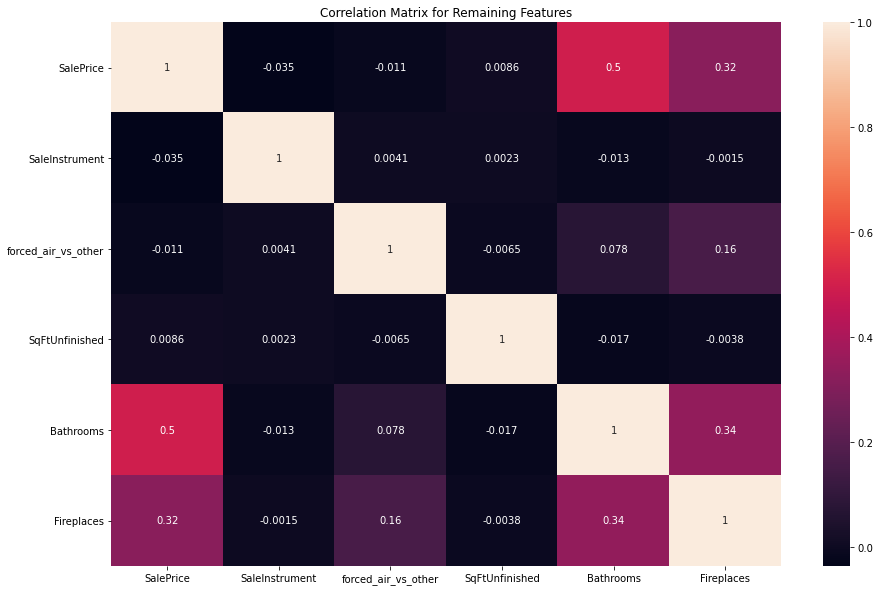

In [45]:
CorrMatrix = df_main.iloc[:, :10].corr()
plt.figure(figsize=(15,10))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Correlation Matrix for First 10 Features');

CorrMatrix = pd.concat([df_main[y], df_main.iloc[:, 10:20]], axis=1).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Correlation Matrix for Next 10 Features')

CorrMatrix = pd.concat([df_main[y], df_main.iloc[:, 20:]], axis=1).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Correlation Matrix for Remaining Features');

In [49]:
correlations = df_main.corr().stack().reset_index()
correlations = correlations.loc[(correlations.level_0 == 'SalePrice') & (correlations.level_1 != 'SalePrice')]
correlations[0] = correlations[0].abs()
correlations.columns = ['Dependent', 'Feature', 'Correlation (abs)']

correlations.sort_values(by='Correlation (abs)', ascending=False, inplace=True)
correlations.reset_index(inplace=True, drop=True)
listed = list(correlations.loc[correlations['Correlation (abs)'] > 0.1].Feature.values)


df_main[listed]

,SqFtTotLiving,BldgGrade,Bathrooms,Fireplaces,SqFtOpenPorch,Bedrooms,SqFtTotBasement,Stories,FinBasementGrade,SqFtDeck,ViewUtilization,SqFtGarageAttached,HeatSystem,YrRenovated,DaylightBasement
0,1480,7,2.00,1,80,3,0,1.0,0,120,NaN,440,5,0,NaN
1,550,5,0.75,0,0,2,0,1.0,0,0,NaN,0,1,0,NaN
2,1540,9,2.25,1,0,3,380,2.0,8,155,1.0,0,1,0,1.0
3,2780,8,1.75,2,0,6,1390,1.0,7,100,0.0,0,5,0,1.0
4,2230,8,2.00,1,40,3,1280,1.0,7,100,NaN,80,5,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18138,1910,8,2.25,0,70,3,620,1.0,8,100,0.0,0,5,0,1.0
18139,3220,9,3.00,1,0,4,0,2.0,0,0,0.0,630,5,0,0.0
18140,960,7,1.00,1,110,3,0,1.5,0,0,NaN,420,5,0,NaN
18141,2010,8,2.50,1,0,4,0,2.0,0,0,0.0,440,5,0,0.0
